**Function Set:**

Let $U = {u_0, u_1, ..., u_n}$ represent a set of basis functions. We will use Chebyshev polynomials for this.

**Construct the Approximation:**

$\tilde{u} = \sum_{k=0}^n c_k u_k \in U$ $c_k$ is the contribution of each polynomial in the approximation. We will solve the coefficients using the Remez exchange algorithm.

**Define Error Function:**

$η(f, I) := inf_{u \in U} max_{x \in I} |f(x) - u(x)|$ where I is the interval over which the function is defined.

**Linear Programming Problem:** Minimize η

subject to:

$-η \leq f(x_i) - \sum_{k=0}^n c_k u_k(x_i) \leq η ∀i=0,1,…,m$ where $x_i$ are discrete sample points.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.optimize import minimize
from scipy.special import binom

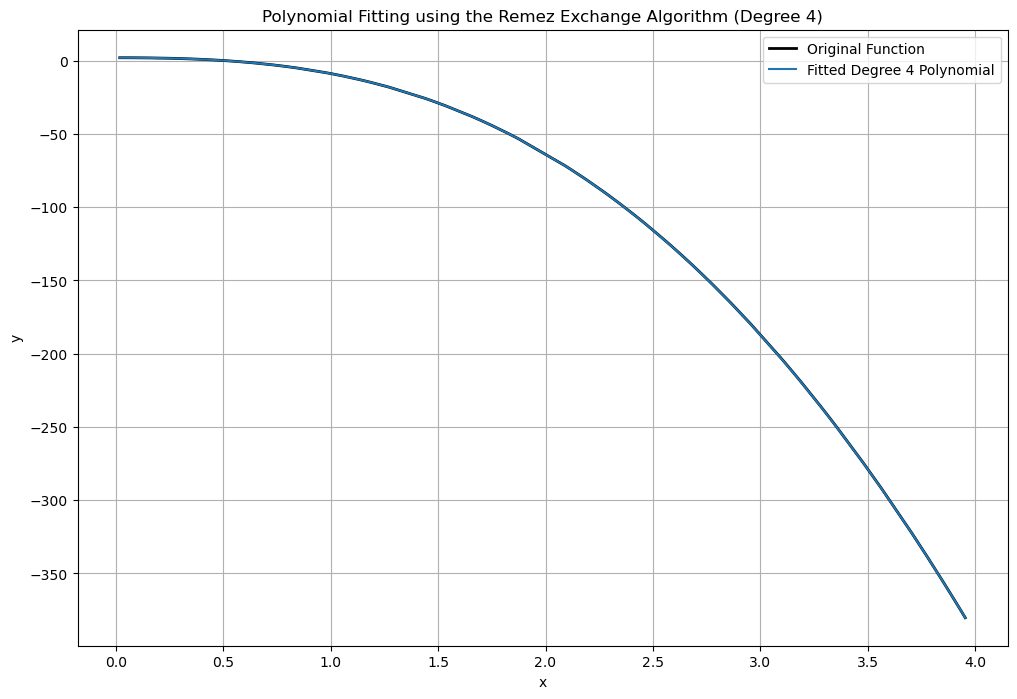

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq

np.random.seed(0)  # for reproducibility
x_data = np.random.uniform(0, 4, 100)
y_data = 0.5 * x_data**4 - 7.1 * x_data**3 - 4.2 * x_data**2 + 2

sorted_indices = np.argsort(x_data)
x_data = x_data[sorted_indices]
y_data = y_data[sorted_indices]

def chebyshev_nodes(n, a, b):
    return 0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * np.arange(n) + 1) / (2 * n) * np.pi)

def fit_remez(x, y, degree, max_iter=100, tol=1e-6):
    num_extremal_points = degree + 2
    extremal_points = chebyshev_nodes(num_extremal_points, x.min(), x.max())

    for iteration in range(max_iter):
        A = np.vander(extremal_points, degree + 1, increasing=True)
        A = np.hstack([A, ((-1) ** np.arange(num_extremal_points))[:, None]]) # The matrix A is horizontally stacked with a column vector of alternating signs and it implements the Chebyshev alternation theorem
        y_extremal = np.interp(extremal_points, x, y) # to find the values of the function y at the current set of extremal points

        solution, residuals, rank, s = lstsq(A, y_extremal, rcond=None)
        coeffs = solution[:-1]
        max_error = solution[-1]

        poly_fit = np.polyval(coeffs[::-1], x)
        errors = np.abs(y - poly_fit)

        if max(errors) < tol:  # Check if max error is below tolerance. If it is, the algorithm converged
            return coeffs

        new_extremal_indices = np.argsort(errors)[-num_extremal_points:]
        new_extremal_points = x[new_extremal_indices]

        if np.array_equal(new_extremal_indices, np.argsort(errors)[-num_extremal_points:]):
            return coeffs  # If extremal points do not change, assume convergence

        extremal_points = new_extremal_points

    raise ValueError("Remez exchange algorithm did not converge.")

try:
    coeffs = fit_remez(x_data, y_data, 4)
    poly_fit = np.polyval(coeffs[::-1], x_data)
    plt.figure(figsize=(12, 8))
    plt.plot(x_data, y_data, label="Original Function", color="black", linewidth=2)
    plt.plot(x_data, poly_fit, label="Fitted Degree 4 Polynomial")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Polynomial Fitting using the Remez Exchange Algorithm (Degree 4)")
    plt.legend()
    plt.grid(True)
    plt.show()
except ValueError as e:
    print("Error fitting polynomial of degree 4:", str(e))


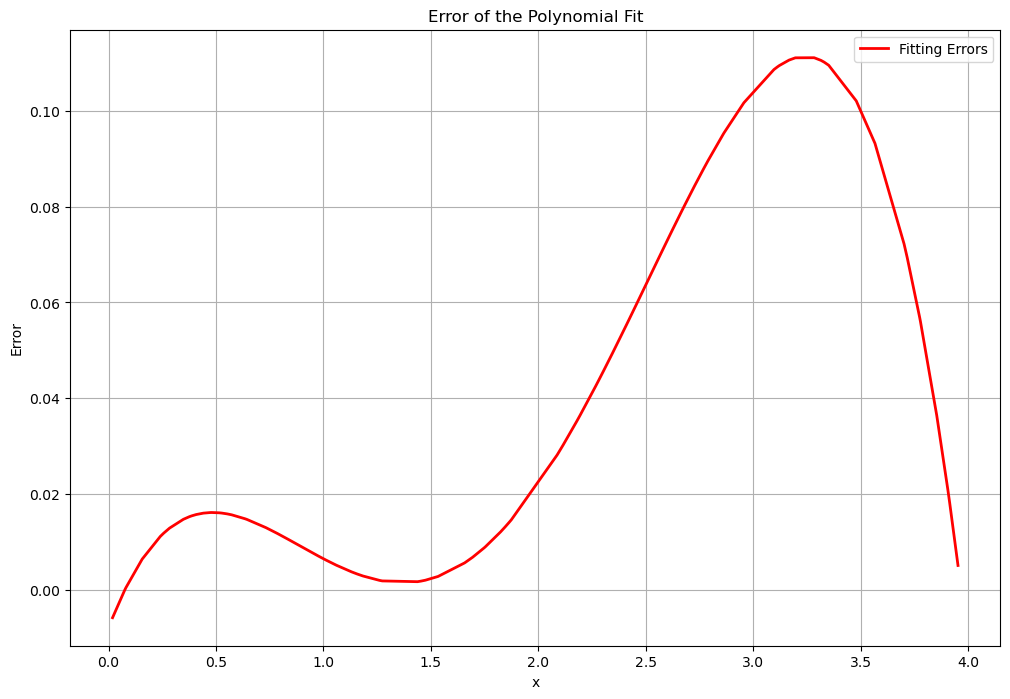

Maximum Error: 0.11107977714675599
Average Error: 0.03817282133660708


In [3]:
errors = y_data - poly_fit
max_error = np.max(np.abs(errors))
avg_error = np.mean(np.abs(errors))

plt.figure(figsize=(12, 8))
plt.plot(x_data, errors, label='Fitting Errors', color='red', linewidth=2)
plt.xlabel("x")
plt.ylabel("Error")
plt.title("Error of the Polynomial Fit")
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum Error: {max_error}")
print(f"Average Error: {avg_error}")


Bezier curve of degree n in a plane is defined by n + 1 control points $P_0, P_1, ..., P_n$ and the curve equation:

$B(t) = \sum_{i=0}^n P_i \binom{n}{i} (1-t)^{n-i}t^i$ for $t \in [0,1]$

**Least Squares Norm**

The objective is to minimize the average squared distance between the points on the actual circular arc and the points on the Bézier curve:

$min \int_{0}^{1} ||C(t) - B(t)||^2dt$ where $C(t)$ represents the parametrization of the circular arc

**Uniform Norm**

The objective is to minimize the maximum distance at any point t between the actual arc and the Bézier curve:

$min max_{t \in [0,1]} ||C(t)-B(t)||$

Parametrize the circular arc C(t):

Convert to polar representation $(1, l-\alpha t)$:

$C(t) = (cos(l-\alpha t), sin(l- \alpha t)$

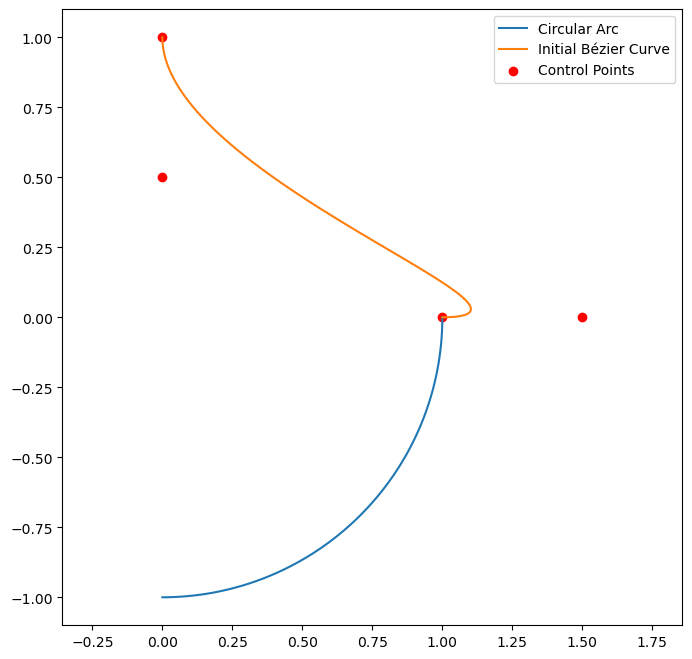

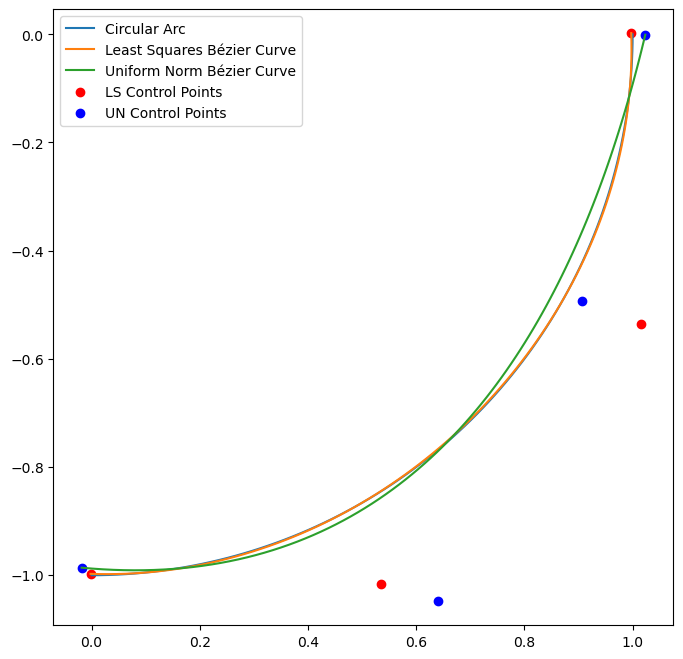

In [24]:
l = 0  # Start angle
alpha = np.pi / 2  # End angle, up to 90 degrees

# Convert to polar representation (1,𝑙−𝛼𝑡)
t = np.linspace(0, 1, 100)
x_arc = np.cos(l - alpha * t)
y_arc = np.sin(l - alpha * t)

P0 = np.array([1, 0])  # Start point
P3 = np.array([0, 1])  # End point
P1 = P0 + np.array([0.5, 0])  # Control point 1
P2 = P3 - np.array([0, 0.5])  # Control point 2
control_points = np.array([P0, P1, P2, P3])

def bezier(t, control_points):
    P0, P1, P2, P3 = control_points
    t = t[:, np.newaxis]
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

plt.figure(figsize=(8, 8))
plt.plot(x_arc, y_arc, label='Circular Arc')
bezier_points = bezier(t, control_points)
plt.plot(bezier_points[:, 0], bezier_points[:, 1], label='Initial Bézier Curve')
plt.scatter(control_points[:, 0], control_points[:, 1], color='red', label='Control Points')
plt.axis('equal')
plt.legend()
plt.show()

def least_squares_error(control_points):
    control_points = control_points.reshape((4, 2))
    bezier_points = bezier(t, control_points)
    return np.sum((bezier_points - np.column_stack((x_arc, y_arc)))**2)

def uniform_norm_error(control_points):
    control_points = control_points.reshape((4, 2))
    bezier_points = bezier(t, control_points)
    return np.max(np.linalg.norm(bezier_points - np.column_stack((x_arc, y_arc)), axis=1))

result_ls = minimize(least_squares_error, control_points.ravel(), method='BFGS')
optimized_control_points_ls = result_ls.x.reshape((4, 2))

result_un = minimize(uniform_norm_error, control_points.ravel(), method='BFGS')
optimized_control_points_un = result_un.x.reshape((4, 2))

plt.figure(figsize=(8, 8))
plt.plot(x_arc, y_arc, label='Circular Arc')
plt.plot(bezier(t, optimized_control_points_ls)[:, 0], bezier(t, optimized_control_points_ls)[:, 1], label='Least Squares Bézier Curve')
plt.plot(bezier(t, optimized_control_points_un)[:, 0], bezier(t, optimized_control_points_un)[:, 1], label='Uniform Norm Bézier Curve')
plt.scatter(optimized_control_points_ls[:, 0], optimized_control_points_ls[:, 1], color='red', label='LS Control Points')
plt.scatter(optimized_control_points_un[:, 0], optimized_control_points_un[:, 1], color='blue', label='UN Control Points')
plt.axis('equal')
plt.legend()
plt.show()

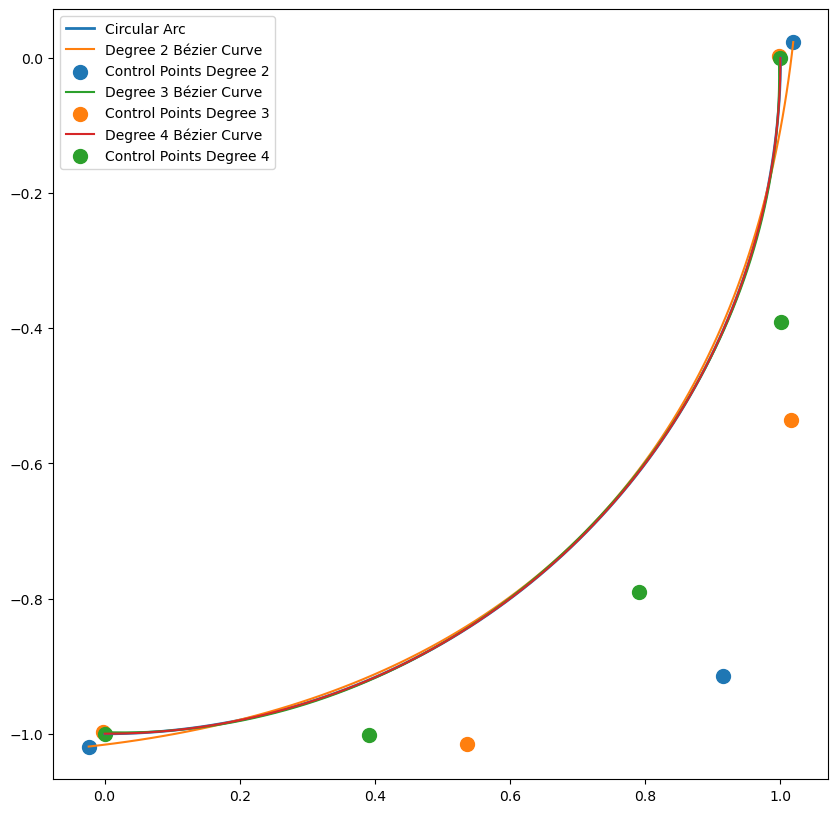

In [28]:
control_points = {
    2: np.array([[1, 0], [0.5, 0.5], [0, 1]]), # 3 control points for 2nd degree
    3: np.array([[1, 0], [0.7, 0.3], [0.3, 0.7], [0, 1]]), # 4 control points for 3rd degree
    4: np.array([[1, 0], [0.8, 0.2], [0.6, 0.4], [0.2, 0.8], [0, 1]]) # 5 control points for 4th degree
}

def bezier(t, control_points):
    n = len(control_points) - 1
    curve = np.zeros((len(t), 2))
    t = t[:, np.newaxis]
    for i, P in enumerate(control_points):
        curve += P * binom(n, i) * (1 - t)**(n - i) * t**i
    return curve

def least_squares_error(control_points_flat, degree, t, x_arc, y_arc):
    control_points = control_points_flat.reshape(-1, 2)
    bezier_points = bezier(t, control_points)
    return np.sum((bezier_points - np.column_stack((x_arc, y_arc)))**2)

results = {}
for degree in [2, 3, 4]:
    result = minimize(least_squares_error, control_points[degree].ravel(),
                      args=(degree, t, x_arc, y_arc), method='BFGS')
    results[degree] = result.x.reshape(-1, 2)

plt.figure(figsize=(10, 10))
plt.plot(x_arc, y_arc, label='Circular Arc', linewidth=2)
for degree, cps in results.items():
    bezier_points = bezier(t, cps)
    plt.plot(bezier_points[:, 0], bezier_points[:, 1], label=f'Degree {degree} Bézier Curve')
    plt.scatter(cps[:, 0], cps[:, 1], s=100, label=f'Control Points Degree {degree}')
plt.axis('equal')
plt.legend()
plt.show()

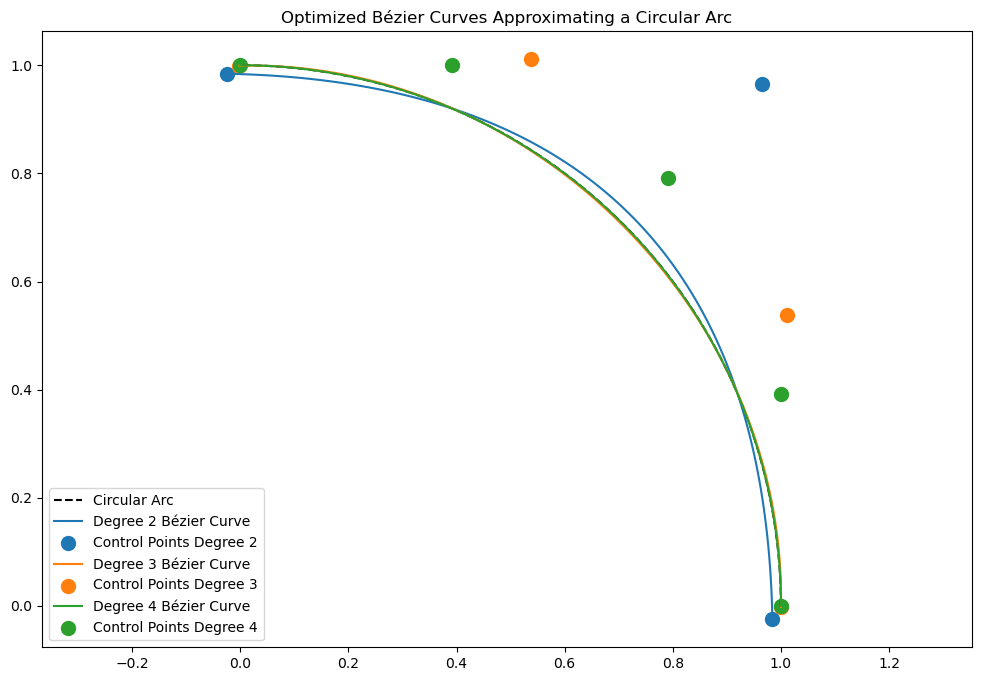

In [30]:
def circle_arc(t, radius=1, center=(0, 0)):
    return np.array([center[0] + radius * np.cos(np.pi * t / 2),
                     center[1] + radius * np.sin(np.pi * t / 2)]).T

def uniform_norm_error(params, degree, t, arc_points):
    control_points = params.reshape(-1, 2)
    bezier_points = bezier(t, control_points)
    return np.max(np.linalg.norm(bezier_points - arc_points, axis=1))

arc_points = circle_arc(t)

init_control_points = {
    2: np.array([[1, 0], [1, 1], [0, 1]]),
    3: np.array([[1, 0], [1, 0.5], [0.5, 1], [0, 1]]),
    4: np.array([[1, 0], [1, 0.33], [0.67, 0.67], [0.33, 1], [0, 1]])
}

results = {}

for degree, init_points in init_control_points.items():
    result = minimize(uniform_norm_error, init_points.ravel(),
                      args=(degree, t, arc_points), method='BFGS')
    results[degree] = result.x.reshape(-1, 2)

plt.figure(figsize=(12, 8))
plt.plot(arc_points[:, 0], arc_points[:, 1], 'k--', label='Circular Arc')
for degree, cps in results.items():
    curve_points = bezier_curve(t, cps)
    plt.plot(curve_points[:, 0], curve_points[:, 1], label=f'Degree {degree} Bézier Curve')
    plt.scatter(cps[:, 0], cps[:, 1], s=100, label=f'Control Points Degree {degree}')
plt.axis('equal')
plt.legend()
plt.title('Optimized Bézier Curves Approximating a Circular Arc')
plt.show()
